In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import *
from scipy.stats import norm
import bayesfit as bf

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

# Analysis of 2AFC Attn Task

In psychophysics task participants respond to each trial indicating whether the stimulus presented is more dark or more light.

### Scoring convention

**LARGE AF:** Response Left (color_balance < 0.5) = Dark; Response Right (color_balance > 0.5) = Light.

**SMALL AF:** Response Left (fix color < 0) = Dark; Response Right (fix color > 0) = Light

In [3]:
f_names

['/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-001_0_psyc_2_Logs/sub-001_0_psyc_2_events.tsv',
 '/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-001_0_psyc_1_Logs/sub-001_0_psyc_1_events.tsv']

In [24]:
wd = os.getcwd()
f_names = glob.glob(f"{wd}/logs/psychophys/*/sub-001*1*.tsv")
all_logs = load_data(f_names)
all_logs[all_logs.event_type == 'response']

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
1,0,9.055865,response,1,right,0.0,0.50,0.4,14.411659,0.0,9.055865,14.411659,Logs,1
3,1,10.663797,response,1,left,0.0,0.10,-0.3,16.019590,0.0,10.663797,16.019590,Logs,1
5,2,12.522048,response,1,right,0.0,0.30,-0.1,17.877842,0.0,12.522048,17.877842,Logs,1
7,3,13.880231,response,1,right,0.0,0.85,0.3,19.236025,0.0,13.880231,19.236025,Logs,1
9,4,15.213501,response,1,right,0.0,0.70,0.2,20.569295,0.0,15.213501,20.569295,Logs,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,220,264.537783,response,1,left,0.0,0.85,0.3,269.893577,0.0,264.537783,269.893577,Logs,1
443,221,265.346115,response,1,right,0.0,0.40,0.6,270.701909,0.0,265.346115,270.701909,Logs,1
445,222,266.412788,response,1,left,0.0,0.85,0.1,271.768582,0.0,266.412788,271.768582,Logs,1
447,223,267.379450,response,1,right,0.0,0.90,0.4,272.735244,0.0,267.379450,272.735244,Logs,1


In [25]:
df = all_logs[(all_logs.event_type == 'response')]
# fixed = np.append(np.array(df.color_balance)[1:],[np.array(df.color_balance)[-1]])
# df.color_balance = fixed
df['correct_s'] = np.nan
df['correct_l'] = np.nan

# Color task
true_left_l = df[(df.color_balance < 0.5) & (df.response == 'left')].index
false_left_l = df[(df.color_balance > 0.5) & (df.response == 'left')].index

true_right_l = df[(df.color_balance > 0.5) & (df.response == 'right')].index
false_right_l = df[(df.color_balance < 0.5) & (df.response == 'right')].index

true_left_s = df[(df.fix_intensity < 0) & (df.response == 'left')].index
false_left_s = df[(df.fix_intensity > 0) & (df.response == 'left')].index

true_right_s = df[(df.fix_intensity > 0) & (df.response == 'right')].index
false_right_s = df[(df.fix_intensity < 0) & (df.response == 'right')].index

df.loc[np.hstack((true_left_l,true_right_l)), 'correct_l'] = 1
df.loc[np.hstack((false_left_l,false_right_l)), 'correct_l'] = 0

df.loc[np.hstack((true_left_s,true_right_s)), 'correct_s'] = 1
df.loc[np.hstack((false_left_s,false_right_s)), 'correct_s'] = 0

# df = df.dropna() # drop where color balance = 0.5
df.tail()

# print(f'Total response "right": {sum(df.response == "left")} \
#     \nTotal response "left": {sum(df.response == "right")} \
#     \ntrue_left: {len(true_left)/sum(df.fix_intensity < 0)} \
#     \ntrue_right: {len(true_right)/sum(df.fix_intensity > 0)} \
#     \nfalse_left: {len(false_left)/sum(df.fix_intensity < 0)} \
#     \nfalse_right: {len(false_right)/sum(df.fix_intensity > 0)}')

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run,correct_s,correct_l
441,220,264.537783,response,1,left,0.0,0.85,0.3,269.893577,0.0,264.537783,269.893577,Logs,1,0.0,0.0
443,221,265.346115,response,1,right,0.0,0.40,0.6,270.701909,0.0,265.346115,270.701909,Logs,1,1.0,0.0
445,222,266.412788,response,1,left,0.0,0.85,0.1,271.768582,0.0,266.412788,271.768582,Logs,1,0.0,0.0
447,223,267.379450,response,1,right,0.0,0.90,0.4,272.735244,0.0,267.379450,272.735244,Logs,1,1.0,1.0
449,224,268.321117,response,1,left,0.0,0.40,-0.6,273.676911,0.0,268.321117,273.676911,Logs,1,1.0,1.0


Plot response light v.s. proportion light. Should increase together

### Plot large AF

Diff: 0.1,      	n_correct: 24     	n_trials: 28     	% correct 85.7
Diff: 0.15,      	n_correct: 19     	n_trials: 22     	% correct 86.4
Diff: 0.2,      	n_correct: 16     	n_trials: 18     	% correct 88.9
Diff: 0.3,      	n_correct: 12     	n_trials: 17     	% correct 70.6
Diff: 0.4,      	n_correct: 8     	n_trials: 13     	% correct 61.5
Diff: 0.6,      	n_correct: 12     	n_trials: 25     	% correct 48.0
Diff: 0.7,      	n_correct: 17     	n_trials: 22     	% correct 77.3
Diff: 0.8,      	n_correct: 18     	n_trials: 21     	% correct 85.7
Diff: 0.85,      	n_correct: 25     	n_trials: 29     	% correct 86.2
Diff: 0.9,      	n_correct: 10     	n_trials: 13     	% correct 76.9


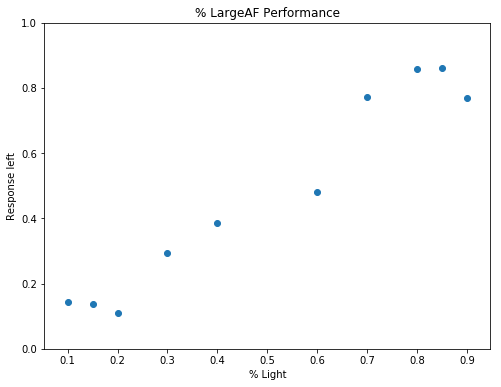

In [5]:
df_l = df[(df.run == '2')]
df_l =  df_l.dropna(subset=['correct_l']) # drop where color balance = 0.5
difficulties_l = sorted(df_l.color_balance.unique())
n_correct_l = []
n_trials_l = []
resp_light_l = []

for diff in difficulties_l:
    print(f'Diff: {diff},  \
    \tn_correct: {len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])} \
    \tn_trials: {len(df_l[df_l.color_balance == diff])} \
    \t% correct {100*len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])/len(df_l[df_l.color_balance == diff]):.1f}')
    n_correct_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)]))
    n_trials_l.append(len(df_l[df_l.color_balance == diff]))
#     print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.color_balance == diff) & (df.response == "right")]) / len(df[df.color_balance == diff]) *100,1)}')
    resp_light_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.response == "right")]) / len(df_l[df_l.color_balance == diff]))

proportions_l = np.array(n_correct_l) / np.array(n_trials_l)

largeAFx, largeAFy = abs(np.array(difficulties_l)-0.5), proportions_l
          
fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% LargeAF Performance')
axs.set_ylabel('Response left')
axs.set_ylim(0,1)
axs.set_xlabel('% Light')
axs.scatter(difficulties_l,resp_light_l)

### Plot small AF

Diff: -0.6           	n_correct: 19            	n_trials: 21           	% correct: 90.5
Diff: -0.4           	n_correct: 21            	n_trials: 28           	% correct: 75.0
Diff: -0.3           	n_correct: 9            	n_trials: 9           	% correct: 100.0
Diff: -0.2           	n_correct: 18            	n_trials: 18           	% correct: 100.0
Diff: -0.1           	n_correct: 15            	n_trials: 22           	% correct: 68.2
Diff: 0.1           	n_correct: 11            	n_trials: 17           	% correct: 64.7
Diff: 0.2           	n_correct: 15            	n_trials: 20           	% correct: 75.0
Diff: 0.3           	n_correct: 19            	n_trials: 24           	% correct: 79.2
Diff: 0.4           	n_correct: 19            	n_trials: 22           	% correct: 86.4
Diff: 0.6           	n_correct: 14            	n_trials: 15           	% correct: 93.3


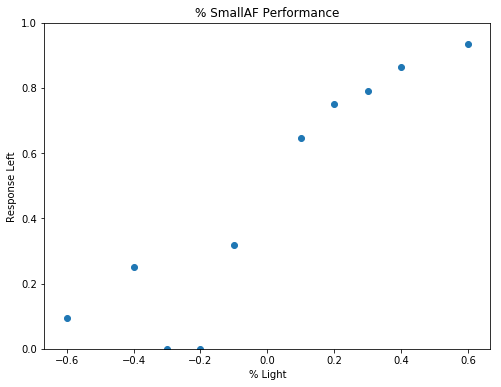

In [26]:
df_s = df[(df.run == '1')]
df_s =  df.dropna(subset=['correct_s']) # drop where fix color = 0
difficulties_s = sorted(df_s.fix_intensity.unique())
n_correct_s = []
n_trials_s = []
resp_light_s = []

for diff in difficulties_s:
    print(f'Diff: {diff} \
          \tn_correct: {len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])}  \
          \tn_trials: {len(df_s[df_s.fix_intensity == diff])} \
          \t% correct: {100*len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])/len(df[df.fix_intensity == diff]):.1f}')
    n_correct_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])) 
    n_trials_s.append(len(df[df.fix_intensity == diff]))
#     print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.fix_intensity == diff) & (df.response == "right")]) / len(df[df.fix_intensity == diff]) *100,1)}')
    resp_light_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.response == "right")]) / len(df_s[df_s.fix_intensity == diff]))

proportions_s = np.array(n_correct_s) / np.array(n_trials_s)

smallAFx, smallAFy = abs(np.array(difficulties_s)), proportions_s
          
fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% SmallAF Performance')
axs.set_ylim(0,1)
axs.set_ylabel('Response Left')
axs.set_xlabel('% Light')
axs.scatter(difficulties_s,resp_light_s)

## Plot difficulty v.s. proportion correct

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].set_title('SmallAF')
axs[0].set_ylabel('Proportion Correct')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('% Light')
axs[0].scatter(smallAFx, smallAFy)

axs[1].set_title('LargeAF')
axs[1].set_ylabel('Proportion Correct')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Distance from 50%')
axs[1].scatter(largeAFx, largeAFy)

# Testing BayesFit

Organize data into `[M X 3 ndarray]` where n is the number of stimulus intensities and the columns are: `[stimulus intensity, N trials correct, and N trials total]`.

In [20]:
data_s = np.vstack((difficulties_s,n_correct_s, n_trials_s)).T

# metrics, options = bf.fitmodel(data_s, nafc = 2)

# Analysis of Attn PRF Detection Task

In [ ]:
f_names = glob.glob("logs/*/*.tsv")
all_logs = load_data(f_names)
all_logs[(all_logs.run == '12')].head()

Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d' and the criterion (c). 

### Summary per run

In [ ]:
psyc, d_primes, large_cor, small_cor = analyse_logs(all_logs)
psyc

We can also calculate d' per difficulty level and plot this to see if two task difficulties are comparable. Unfortunately d' can go to infinity so many points are missing from the performance curves... and we're unsure if they're sigmoidal.

In [ ]:
Z = norm.ppf
d_primes['d_prime']= Z(d_primes['hit_rate'])- Z(d_primes['fa_rate'])
d_primes['criterion'] = -(Z(d_primes['hit_rate']) + Z(d_primes['fa_rate'])) / 2
d_primes.head()

In [ ]:
large_AF = d_primes[d_primes['run'].astype(int) % 2 == 1]
small_AF = d_primes[d_primes['run'].astype(int) % 2 == 0]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('SmallAF')
ax1.scatter(abs(small_AF['difficulty']),small_AF['d_prime'])
ax1.set_ylabel('Dprime')

ax2.set_title('LargeAF')
ax2.scatter(abs(large_AF['difficulty']-0.5),large_AF['d_prime'],color='orange')
ax2.set_ylabel('Dprime')

We can also use proportion correct to create psychometric curves - although these are not traditional sigmoidal psychometric curves which are designed for 2 alternative forced-choice (2AFC) task. 

In [ ]:
largex, largey = (np.array([i[0] for i in large_cor]), 
                  np.array([i[1] for i in large_cor]))
smallx,smally = (np.array([i[0] for i in small_cor]), 
                np.array([i[1] for i in small_cor]))

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

# Fitting a sigmoid function to data

Lastly we can fit a sigmoid function to each of these curves.

[0.05992401 2.50470625]


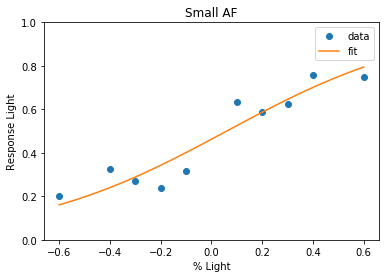

[0.52320962 4.85034093]


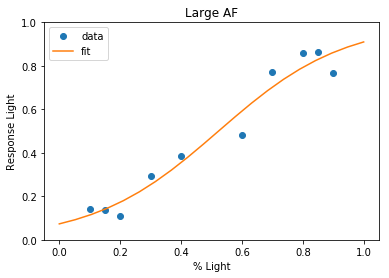

In [22]:
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

# def sigmoid_inv(y,x0,k):
    

xdata = difficulties_s
ydata = resp_light_s

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(-0.6, 0.6, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Small AF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

xdata = difficulties_l
ydata = resp_light_l

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Large AF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

# Modeling psychometric curve

In [ ]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,0.6,0.05)
    mu = 0.3
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

In [ ]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.show()